# The Agent Loop: Building Production Agents with LangChain 1.0

> **Note:** While this notebook can be adapted to use various LLM providers, we'll be using the Anthropic Claude API. Please follow the best practices outlined in the [SRHG AI Usage Guidelines](https://srhg.enterprise.slack.com/docs/T0HANKTEC/F0AB86J3A1L).

In this notebook, we'll explore the foundational concepts of AI agents and learn how to build production-grade agents using LangChain's new `create_agent` abstraction with middleware support. We'll build a **Stone Ridge Investment Assistant** that can answer questions about Stone Ridge's investment philosophy, market insights, and strategic outlook.

**Learning Objectives:**
- Understand what an "agent" is and how the agent loop works
- Learn the core constructs of LangChain (Runnables, LCEL)
- Master the `create_agent` function and middleware system
- Build an agentic RAG application using Qdrant for Stone Ridge investor letters

## Table of Contents:

- **Part 1:** Introduction to LangChain, LangSmith, and `create_agent`
  - Task 1: Dependencies
  - Task 2: Environment Variables
  - Task 3: LangChain Core Concepts (Runnables & LCEL)
  - Task 4: Understanding the Agent Loop
  - Task 5: Building Your First Agent with `create_agent()`
  - Question #1 & Question #2
  - Activity #1: Create a Custom Tool

- **Part 2:** Middleware - Agentic RAG with Qdrant
  - Task 6: Loading & Chunking Documents
  - Task 7: Setting up Qdrant Vector Database
  - Task 8: Creating a RAG Tool
  - Task 9: Introduction to Middleware
  - Task 10: Building Agentic RAG with Middleware
  - Question #3 & Question #4
  - Activity #2: Enhance the Agent

---
# Part 1
## Introduction to LangChain, LangSmith, and `create_agent`

## Task 1: Dependencies

First, let's ensure we have all the required packages installed. We'll be using:

- **LangChain 1.0+**: The core framework with the new `create_agent` API
- **LangChain-Anthropic**: Anthropic Claude model integrations
- **LangChain-OpenAI**: OpenAI embeddings (we'll use Claude for chat, OpenAI for embeddings)
- **LangSmith**: Observability and tracing
- **Qdrant**: Vector database for RAG
- **PyMuPDF**: PDF parsing for investor letters

In [ ]:
# Run this cell to install dependencies (if not using uv sync)
# !pip install langchain>=1.0.0 langchain-anthropic langchain-openai langsmith langgraph qdrant-client langchain-qdrant pymupdf nest-asyncio

In [2]:
# Core imports we'll use throughout the notebook
import os
import getpass
from uuid import uuid4

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

## Task 2: Environment Variables

We need to set up our API keys for:
1. **Anthropic** - For Claude models (chat/reasoning)
2. **OpenAI** - For embeddings (text-embedding-3-small)
3. **LangSmith** - For tracing and observability (optional but recommended)

In [ ]:
# Set Anthropic API Key (for Claude chat models)
os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Anthropic API Key: ")

# Set OpenAI API Key (for embeddings)
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key (for embeddings): ")

In [4]:
# Optional: Set up LangSmith for tracing
# This provides powerful debugging and observability for your agents

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - The Agent Loop - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE9 - The Agent Loop - 897a3674


## Task 3: LangChain Core Concepts

Before diving into agents, let's understand the fundamental building blocks of LangChain.

### What is a Runnable?

A **Runnable** is the core abstraction in LangChain - think of it as a standardized component that:
- Takes an input
- Performs some operation
- Returns an output

Every component in LangChain (models, prompts, retrievers, parsers) is a Runnable, which means they all share the same interface:

```python
result = runnable.invoke(input)           # Single input
results = runnable.batch([input1, input2]) # Multiple inputs
for chunk in runnable.stream(input):       # Streaming
    print(chunk)
```

### What is LCEL (LangChain Expression Language)?

**LCEL** allows you to chain Runnables together using the `|` (pipe) operator:

```python
chain = prompt | model | output_parser
result = chain.invoke({"query": "Hello!"})
```

This is similar to Unix pipes - the output of one component becomes the input to the next.

In [ ]:
# Let's see LCEL in action with a simple example
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Create our components (each is a Runnable)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that speaks like a pirate."),
    ("human", "{question}")
])

model = ChatAnthropic(model="claude-sonnet-4-20250514", temperature=0.7)

output_parser = StrOutputParser()

# Chain them together with LCEL
pirate_chain = prompt | model | output_parser

In [6]:
# Invoke the chain
response = pirate_chain.invoke({"question": "What is the capital of France?"})
print(response)

Arrr, that be Paris, matey!


## Task 4: Understanding the Agent Loop

### What is an Agent?

An **agent** is a system that uses an LLM to decide what actions to take. Unlike a simple chain that follows a fixed sequence, an agent can:

1. **Reason** about what to do next
2. **Take actions** by calling tools
3. **Observe** the results
4. **Iterate** until the task is complete

### The Agent Loop

The core of every agent is the **agent loop**:

```
                          AGENT LOOP                         
                                                             
      +----------+     +----------+     +----------+         
      |  Model   | --> |   Tool   | --> |  Model   | --> ... 
      |   Call   |     |   Call   |     |   Call   |         
      +----------+     +----------+     +----------+         
           |                                  |              
           v                                  v              
      "Use search"                   "Here's the answer"     
```

1. **Model Call**: The LLM receives the current state and decides whether to:
   - Call a tool (continue the loop)
   - Return a final answer (exit the loop)

2. **Tool Call**: If the model decides to use a tool, the tool is executed and its output is added to the conversation

3. **Repeat**: The loop continues until the model decides it has enough information to answer

### Why `create_agent`?

LangChain 1.0 introduced `create_agent` as the new standard way to build agents. It provides:

- **Simplified API**: One function to create production-ready agents
- **Middleware Support**: Hook into any point in the agent loop
- **Built on LangGraph**: Uses the battle-tested LangGraph runtime under the hood

## Task 5: Building Your First Agent with `create_agent()`

Let's build a simple agent that can perform calculations and tell the time.

### Step 1: Define Tools

Tools are functions that the agent can call. We use the `@tool` decorator to create them.

In [7]:
from langchain_core.tools import tool

@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

@tool
def get_current_time() -> str:
    """Get the current date and time. Use this when the user asks about the current time or date."""
    from datetime import datetime
    return f"The current date and time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# Create our tool belt
tools = [calculate, get_current_time]

print("Tools created:")
for t in tools:
    print(f"  - {t.name}: {t.description[:60]}...")

Tools created:
  - calculate: Evaluate a mathematical expression. Use this for any math ca...
  - get_current_time: Get the current date and time. Use this when the user asks a...


### Step 2: Create the Agent

Now we use `create_agent` to build our agent. The function takes:
- `model`: The LLM to use (can be a string like `"gpt-5"` or a model instance)
- `tools`: List of tools the agent can use
- `prompt`: Optional system prompt to customize behavior

In [ ]:
from langchain.agents import create_agent

# Create the Claude model for our agent
claude_model = ChatAnthropic(model="claude-sonnet-4-20250514", temperature=0)

# Create our first agent
simple_agent = create_agent(
    model=claude_model,
    tools=tools,
    system_prompt="You are a helpful assistant that can perform calculations and tell the time. Always explain your reasoning."
)

print("Agent created successfully!")
print(f"Type: {type(simple_agent)}")

### Step 3: Run the Agent

The agent is a Runnable, so we can invoke it like any other LangChain component.

In [10]:
# Test the agent with a simple calculation
response = simple_agent.invoke(
    {"messages": [{"role": "user", "content": "What is 25 * 48?"}]}
)

# Print the final response
print("Agent Response:")
print(response["messages"][-1].content)

Agent Response:
25 × 48 = 1200.

Reasoning:
- 25 × 48 = 25 × (50 − 2) = 25×50 − 25×2 = 1250 − 50 = 1200.


In [11]:
# Test with a multi-step question that requires multiple tool calls
response = simple_agent.invoke(
    {"messages": [{"role": "user", "content": "What time is it, and what is 100 divided by the current hour?"}]}
)

print("Agent Response:")
print(response["messages"][-1].content)

Agent Response:
- Current time: 2026-01-19 15:13:29 (3:13:29 PM).
- Calculation: The current hour is 15, so 100 ÷ 15 = 6.6666666667 (repeating), i.e., 20/3.


In [12]:
# Let's see the full conversation to understand the agent loop
print("Full Agent Conversation:")
print("=" * 50)
for msg in response["messages"]:
    role = msg.type if hasattr(msg, 'type') else 'unknown'
    content = msg.content if hasattr(msg, 'content') else str(msg)
    print(f"\n[{role.upper()}]")
    print(content[:500] if len(str(content)) > 500 else content)

Full Agent Conversation:

[HUMAN]
What time is it, and what is 100 divided by the current hour?

[AI]


[TOOL]
The current date and time is: 2026-01-19 15:13:29

[AI]


[TOOL]
The result of 100 / 15 is 6.666666666666667

[AI]
- Current time: 2026-01-19 15:13:29 (3:13:29 PM).
- Calculation: The current hour is 15, so 100 ÷ 15 = 6.6666666667 (repeating), i.e., 20/3.


### Streaming Agent Responses

For better UX, we can stream the agent's responses as they're generated.

In [13]:
# Stream the agent's response
print("Streaming Agent Response:")
print("=" * 50)

for chunk in simple_agent.stream(
    {"messages": [{"role": "user", "content": "Calculate 15% of 250"}]},
    stream_mode="updates"
):
    for node, values in chunk.items():
        print(f"\n[Node: {node}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(msg.content)

Streaming Agent Response:

[Node: model]

[Node: tools]
The result of 0.15 * 250 is 37.5

[Node: model]
To find 15% of 250, multiply 250 by 0.15:
250 × 0.15 = 37.5

Answer: 37.5


---
## ❓ Question #1:

In the agent loop, what determines whether the agent continues to call tools or returns a final answer to the user? How does `create_agent` handle this decision internally?

##### ✅ Answer:
*Your answer here*

## ❓ Question #2:

Looking at the `calculate` and `get_current_time` tools we created, why is the **docstring** so important for each tool? How does the agent use this information when deciding which tool to call?

##### ✅ Answer:
*Your answer here*

---
## 🏗️ Activity #1: Create a Custom Tool

Create your own custom tool and add it to the agent! 

Ideas:
- A tool that converts temperatures between Celsius and Fahrenheit
- A tool that generates a random number within a range
- A tool that counts words in a given text

Requirements:
1. Use the `@tool` decorator
2. Include a clear docstring (this is what the agent sees!)
3. Add it to the agent and test it

In [ ]:
### YOUR CODE HERE ###

# Create your custom tool
@tool
def my_custom_tool():
    """Your tool description here - be clear about what it does!"""
    pass

# Add your tool to the tools list and create a new agent


In [ ]:
# Test your custom tool with the agent


---
# Part 2
## Middleware - Agentic RAG with Qdrant

Now that we understand the basics of agents, let's build something more powerful: an **Agentic RAG** system.

Traditional RAG follows a fixed pattern: retrieve → generate. But **Agentic RAG** gives the agent control over when and how to retrieve information, making it more flexible and intelligent.

We'll also introduce **middleware** - hooks that let us customize the agent's behavior at every step.

## Task 6: Loading & Chunking Documents

We'll use the Stone Ridge 2025 Investor Letter - the same document from Module 2 - to build our investment assistant.

In [ ]:
# Load the document using PyMuPDF for PDF parsing
from aimakerspace.text_utils import PDFFileLoader, CharacterTextSplitter

# Load the Stone Ridge investor letter
pdf_loader = PDFFileLoader("data/Stone Ridge 2025 Investor Letter.pdf")
documents = pdf_loader.load_documents()

print(f"Loaded {len(documents)} document(s)")
print(f"Total characters: {sum(len(doc) for doc in documents):,}")

In [ ]:
# Split the documents into chunks
text_splitter = CharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)

chunks = text_splitter.split_texts(documents)

print(f"Split into {len(chunks)} chunks")
print(f"\nSample chunk:")
print("-" * 50)
print(chunks[0][:300] + "...")

## Task 7: Setting up Qdrant Vector Database

Qdrant is a production-ready vector database. We'll use an in-memory instance for development, but the same code works with a hosted Qdrant instance.

Key concepts:
- **Collection**: A namespace for storing vectors (like a table in SQL)
- **Points**: Individual vectors with optional payloads (metadata)
- **Distance**: How similarity is measured (we'll use cosine similarity)

We'll use OpenAI's `text-embedding-3-small` for embeddings - it provides excellent quality for semantic search over financial documents.

In [16]:
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Initialize the embedding model
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Get embedding dimension
sample_embedding = embedding_model.embed_query("test")
embedding_dim = len(sample_embedding)
print(f"Embedding dimension: {embedding_dim}")

Embedding dimension: 1536


In [ ]:
# Create Qdrant client (in-memory for development)
qdrant_client = QdrantClient(":memory:")

# Create a collection for our investment documents
collection_name = "investment_knowledge_base"

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=embedding_dim,
        distance=Distance.COSINE
    )
)

print(f"Created collection: {collection_name}")

In [18]:
# Create the vector store and add documents
from langchain_core.documents import Document

# Convert chunks to LangChain Document objects
langchain_docs = [Document(page_content=chunk) for chunk in chunks]

# Create vector store
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embedding_model
)

# Add documents to the vector store
vector_store.add_documents(langchain_docs)

print(f"Added {len(langchain_docs)} documents to vector store")

Added 41 documents to vector store


In [ ]:
# Test the retriever
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

test_results = retriever.invoke("What is Stone Ridge's investment philosophy?")

print("Retrieved documents:")
for i, doc in enumerate(test_results, 1):
    print(f"\n--- Document {i} ---")
    print(doc.page_content[:200] + "...")

## Task 8: Creating a RAG Tool

Now we'll wrap our retriever as a tool that the agent can use. This is the key to **Agentic RAG** - the agent decides when to retrieve information about Stone Ridge's investment philosophy and strategy.

In [ ]:
from langchain_core.tools import tool

@tool
def search_investment_knowledge(query: str) -> str:
    """Search the Stone Ridge investment knowledge base for information about investment philosophy, market insights, and strategic outlook.
    
    Use this tool when the user asks questions about:
    - Stone Ridge's investment philosophy and approach
    - Market analysis and insights from investor letters
    - Strategic outlook and portfolio positioning
    - Company updates and business developments
    - Historical performance context and investment themes
    
    Args:
        query: The search query to find relevant investment information
    """
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the investment knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return "\n\n".join(formatted_results)

print(f"Tool created: {search_investment_knowledge.name}")
print(f"Description: {search_investment_knowledge.description[:100]}...")

## Task 9: Introduction to Middleware

**Middleware** in LangChain 1.0 allows you to hook into the agent loop at various points:

```
                       MIDDLEWARE HOOKS                 
                                                        
   +--------------+                    +--------------+ 
   | before_model | --> MODEL CALL --> | after_model  | 
   +--------------+                    +--------------+ 
                                                        
   +-------------------+                                
   | wrap_model_call   |  (intercept and modify calls)  
   +-------------------+                                
```

Common use cases:
- **Logging**: Track what the agent is doing
- **Guardrails**: Filter or modify inputs/outputs
- **Rate limiting**: Control API usage
- **Human-in-the-loop**: Pause for human approval

LangChain provides middleware through **decorator functions** that hook into specific points in the agent loop.

In [21]:
from langchain.agents.middleware import before_model, after_model

# Track how many model calls we've made
model_call_count = 0

@before_model
def log_before_model(state, runtime):
    """Called before each model invocation."""
    global model_call_count
    model_call_count += 1
    message_count = len(state.get("messages", []))
    print(f"[LOG] Model call #{model_call_count} - Messages in state: {message_count}")
    return None  # Return None to continue without modification

@after_model
def log_after_model(state, runtime):
    """Called after each model invocation."""
    last_message = state.get("messages", [])[-1] if state.get("messages") else None
    if last_message:
        has_tool_calls = hasattr(last_message, 'tool_calls') and last_message.tool_calls
        print(f"[LOG] After model - Tool calls requested: {has_tool_calls}")
    return None

print("Logging middleware created!")

Logging middleware created!


In [22]:
# You can also use the built-in ModelCallLimitMiddleware to prevent runaway agents
from langchain.agents.middleware import ModelCallLimitMiddleware

# This middleware will stop the agent after 10 model calls per thread
call_limiter = ModelCallLimitMiddleware(
    thread_limit=10,  # Max calls per conversation thread
    run_limit=5,      # Max calls per single run
    exit_behavior="end"  # What to do when limit is reached
)

print("Call limit middleware created!")
print(f"  - Thread limit: {call_limiter.thread_limit}")
print(f"  - Run limit: {call_limiter.run_limit}")

Call limit middleware created!
  - Thread limit: 10
  - Run limit: 5


## Task 10: Building Agentic RAG with Middleware

Now let's put it all together: an agentic RAG system with middleware support!

In [ ]:
from langchain.agents import create_agent

# Reset the call counter
model_call_count = 0

# Define our tools - include the RAG tool and the calculator from earlier
rag_tools = [
    search_investment_knowledge,
    calculate,
    get_current_time
]

# Create the Claude model for our RAG agent
claude_rag_model = ChatAnthropic(model="claude-sonnet-4-20250514", temperature=0)

# Create the agentic RAG system with middleware
investment_agent = create_agent(
    model=claude_rag_model,
    tools=rag_tools,
    system_prompt="""You are a helpful Stone Ridge investment assistant with access to a comprehensive knowledge base of investor letters and company information.

Your role is to:
1. Answer questions about Stone Ridge's investment philosophy, market insights, and strategic outlook
2. Always search the knowledge base when the user asks investment-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be professional and informative in your responses
5. If you cannot find relevant information, say so honestly
6. Include a reminder that information is for educational purposes only and not investment advice when appropriate

Remember: Always cite information from the knowledge base when applicable.""",
    middleware=[
        log_before_model,
        log_after_model,
        call_limiter
    ]
)

print("Investment Agent created with middleware!")

In [ ]:
# Test the investment agent
print("Testing Investment Agent")
print("=" * 50)

response = investment_agent.invoke(
    {"messages": [{"role": "user", "content": "What is Stone Ridge's investment philosophy?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

In [ ]:
# Test with a more complex query
print("Testing with complex query")
print("=" * 50)

response = investment_agent.invoke(
    {"messages": [{"role": "user", "content": "What does Stone Ridge say about their energy investments? Also, if they invested $100 million with a 50% return over 12 years, what would be the total value?"}]}
)
print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

In [26]:
# Test the agent's ability to know when NOT to use RAG
print("Testing agent decision-making (should NOT use RAG)")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "What is 125 * 8?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing agent decision-making (should NOT use RAG)
[LOG] Model call #5 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'calculate', 'args': {'expression': '125 * 8'}, 'id': 'call_2dHoGbzFnMcBDLZKdkhzqo6q', 'type': 'tool_call'}]
[LOG] Model call #6 - Messages in state: 3
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
125 * 8 = 1000


### Visualizing the Agent

The agent created by `create_agent` is built on LangGraph, so we can visualize its structure.

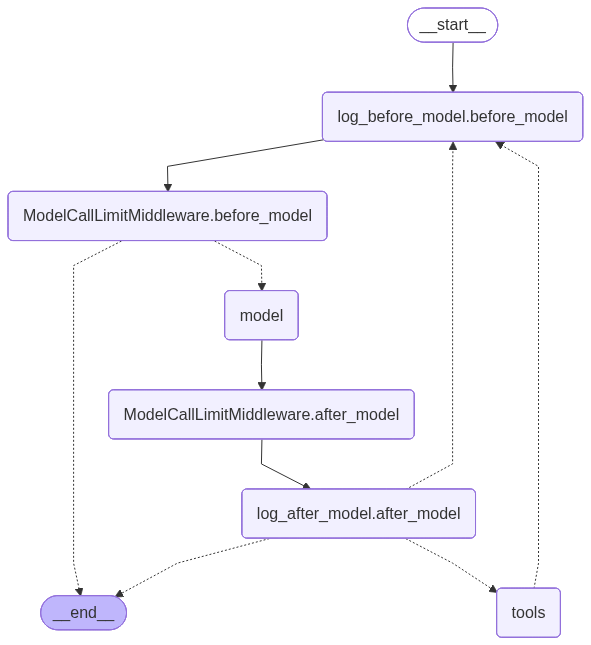

In [30]:
# Display the agent graph
try:
    from IPython.display import display, Image
    display(Image(wellness_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nAgent structure:")
    print(wellness_agent.get_graph().draw_ascii())

---
## ❓ Question #3:

How does **Agentic RAG** differ from traditional RAG? What are the advantages and potential disadvantages of letting the agent decide when to retrieve information from the Stone Ridge investor letters?

##### ✅ Answer:
*Your answer here*

## ❓ Question #4:

Looking at the middleware examples (`log_before_model`, `log_after_model`, and `ModelCallLimitMiddleware`), describe a real-world scenario where middleware would be essential for a production agent. What specific middleware hooks would you use and why?

##### ✅ Answer:
*Your answer here*

---
## 🏗️ Activity #2: Enhance the Agentic RAG System

Now it's your turn! Enhance the investment agent by implementing ONE of the following:

### Option A: Add a New Tool
Create a new tool that the agent can use. Ideas:
- A tool that calculates compound annual growth rate (CAGR)
- A tool that compares investment returns across different time periods
- A tool that formats financial figures with proper notation

### Option B: Create Custom Middleware
Build middleware that adds new functionality:
- Middleware that tracks which tools are used most frequently
- Middleware that adds a compliance disclaimer to investment-related responses
- Middleware that enforces a response length limit

### Option C: Improve the RAG Tool
Enhance the retrieval tool:
- Add metadata filtering by year or topic
- Implement reranking of results for financial relevance
- Add source citations with relevance scores

In [ ]:
### YOUR CODE HERE ###

# Implement your enhancement below


In [ ]:
# Test your enhanced agent here
